In [1]:
import kagglehub
from os import listdir
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

base_path = path+'/'+"IDC_regular_ps50_idx5/"
folder = listdir(base_path)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/phase2'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/phase2/utils')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

from os import listdir
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import CrossEntropyLoss

from sklearn.model_selection import train_test_split

from PIL import Image
from PIL import Image, ImageEnhance

from ph2 import *

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
len(folder)

279

Almost 280 patients. That's a small number compared to the expected number of patients one would like to analyse with our algorithm after deployment. **Consequently overfitting to this specific patient distribution is very likely and we need to take care about the generalization performance of our model**.

### How many patches do we have in total?

Our algorithm needs to decide whether an image patch contains IDC or not. Consequently not the whole patient tissue slice but the single patches have to be considered as input to our algorithm. How many of them do we have in total?

In [7]:
# total_images = 0
# for n in range(len(folder)):
#     patient_id = folder[n]
#     for c in [0, 1]:
#         patient_path = base_path + patient_id
#         class_path = patient_path + "/" + str(c) + "/"
#         subfiles = listdir(class_path)
#         total_images += len(subfiles)
total_images = 277524

Ok, roughly 280000 images. To feed the algorithm with image patches it would be nice to store the path of each image. This way we can load batches of images only one by one without storing the pixel values of all images.

### Storing the image_path, patient_id and the target

In [8]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1

data.head()

<ipython-input-8-985c50b67efc>:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data.iloc[k]["path"] = class_path + image_path
<ipython-input-8-985c50b67efc>:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
Yo

patient_id                                               path target
0      10293  /root/.cache/kagglehub/datasets/paultimothymoo...      0
1      10293  /root/.cache/kagglehub/datasets/paultimothymoo...      0
2      10293  /root/.cache/kagglehub/datasets/paultimothymoo...      0
3      10293  /root/.cache/kagglehub/datasets/paultimothymoo...      0
4      10293  /root/.cache/kagglehub/datasets/paultimothymoo...      0

# Exploratory analysis <a class="anchor" id="eda"></a>

## What do we know about our data? <a class="anchor" id="data"></a>

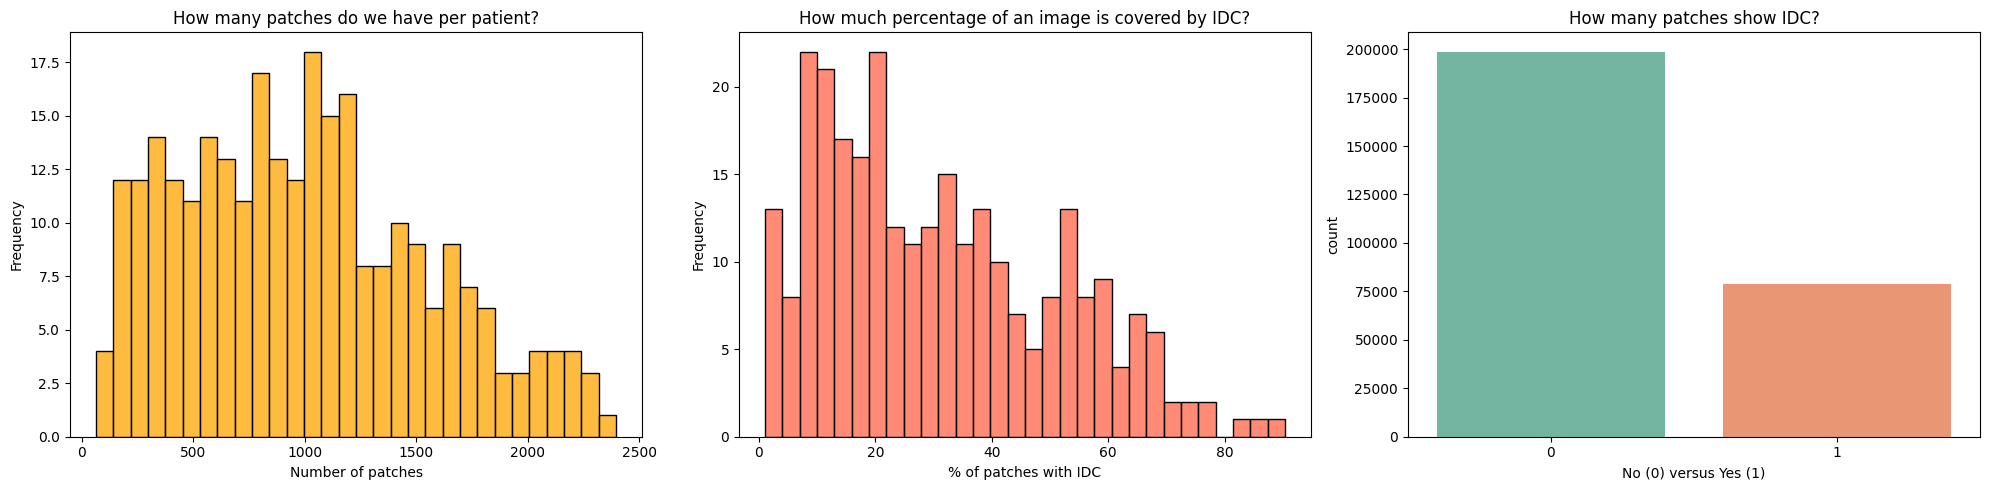

In [9]:
# Calculate cancer percentage per patient
cancer_perc = data.groupby("patient_id")["target"].value_counts(normalize=True).unstack()

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot the distribution of the number of patches per patient
sns.histplot(data.groupby("patient_id").size(), ax=ax[0], color="orange", bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")

# Plot the percentage of patches with IDC
sns.histplot(cancer_perc.loc[:, 1] * 100, ax=ax[1], color="tomato", bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC")

# Plot the count of patches with and without IDC
sns.countplot(x=data["target"], hue=data["target"], palette="Set2", ax=ax[2], legend=False)
ax[2].set_xlabel("No (0) versus Yes (1)")
ax[2].set_title("How many patches show IDC?")

# Adjust layout
plt.tight_layout()
plt.show()

### Insights

1. The number of image patches per patient varies a lot! **This leads to the questions whether all images show the same resolution of tissue cells of if this varies between patients**.
2. Some patients have more than 80 % patches that show IDC! Consequently the tissue is full of cancer or only a part of the breast was covered by the tissue slice that is focused on the IDC cancer. **Does a tissue slice per patient cover the whole region of interest?**
3. The **classes of IDC versus no IDC are imbalanced**. We have to check this again after setting up a validation strategy and find a strategy to deal with class weights (if we like to apply them).

## Looking at healthy and cancer patches <a class="anchor" id="patches"></a>

In [10]:
data.target = data.target.astype(int)
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

### Cancer patches

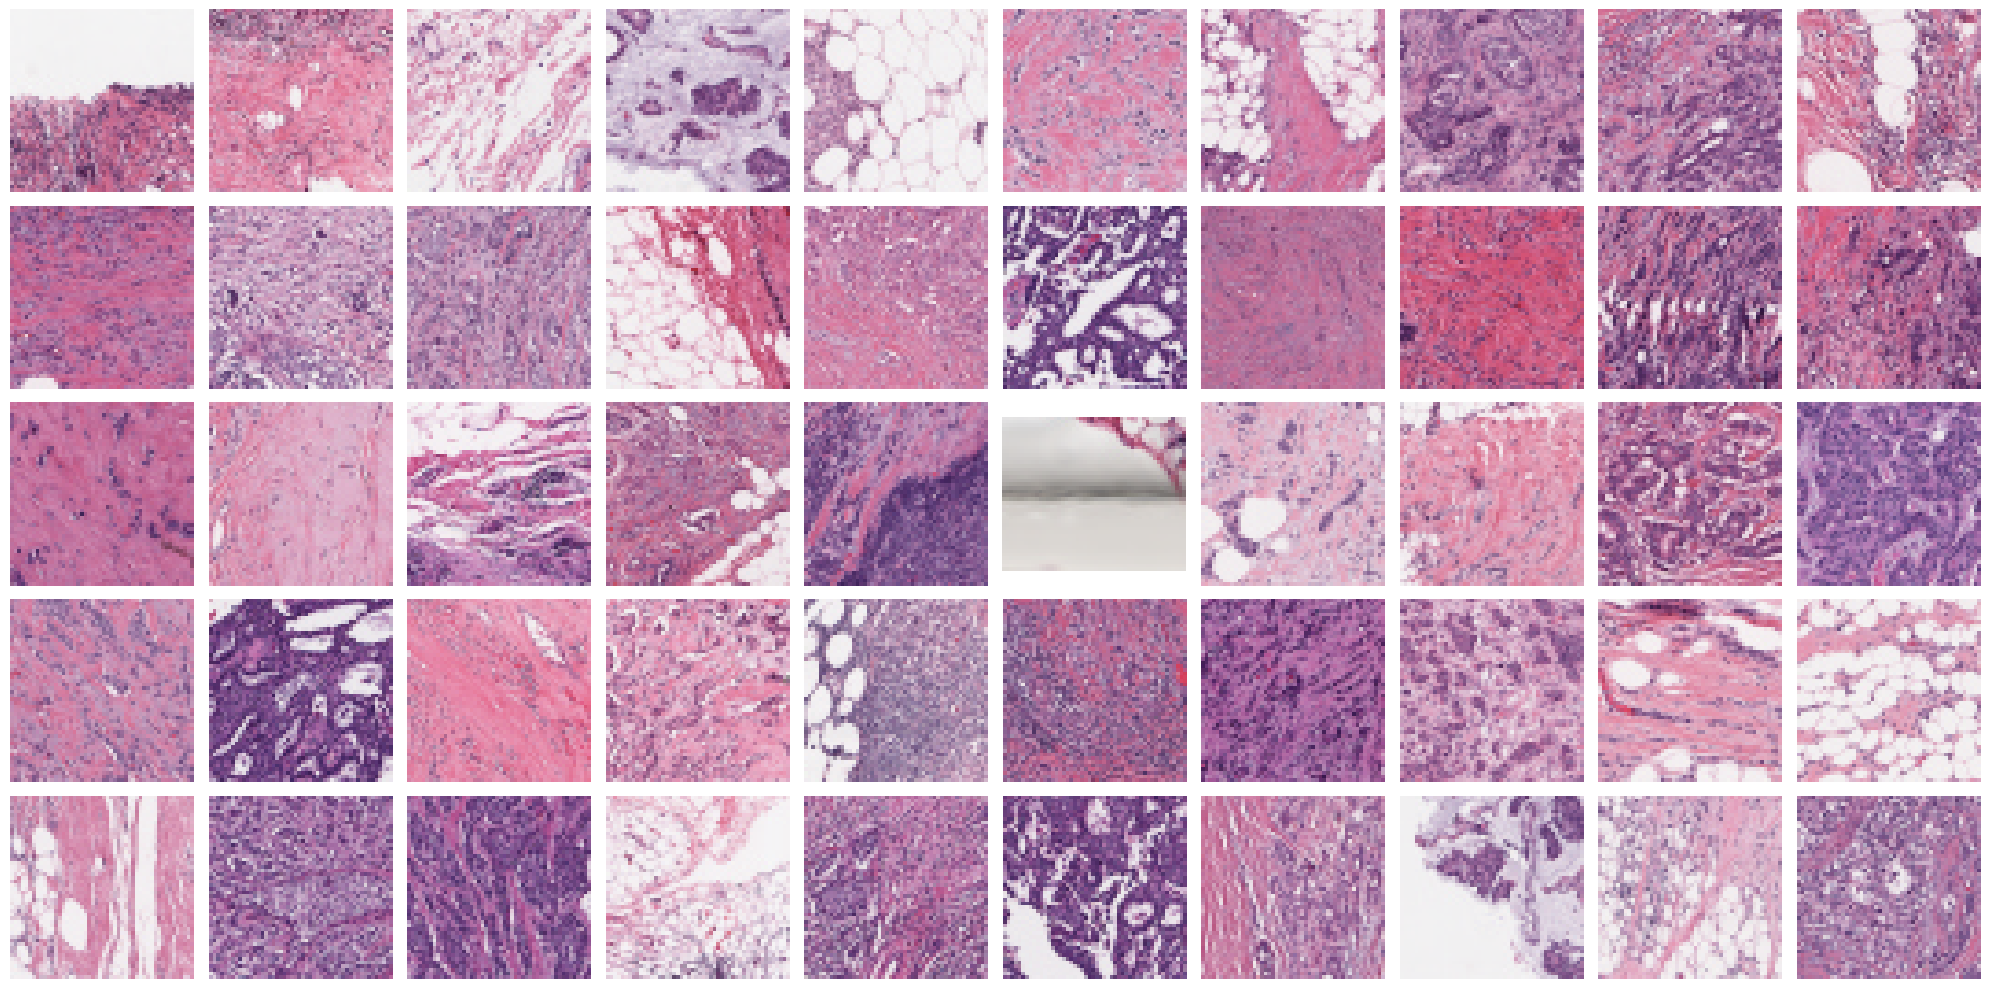

In [11]:
# Create a figure with subplots
fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10 * n]  # Get the index of the image
        image = mpimg.imread(data.loc[idx, "path"])  # Read the image
        ax[n, m].imshow(image)  # Display the image
        ax[n, m].axis("off")  # Turn off axes for a cleaner look

# Adjust layout
plt.tight_layout()
plt.show()

### Healthy patches

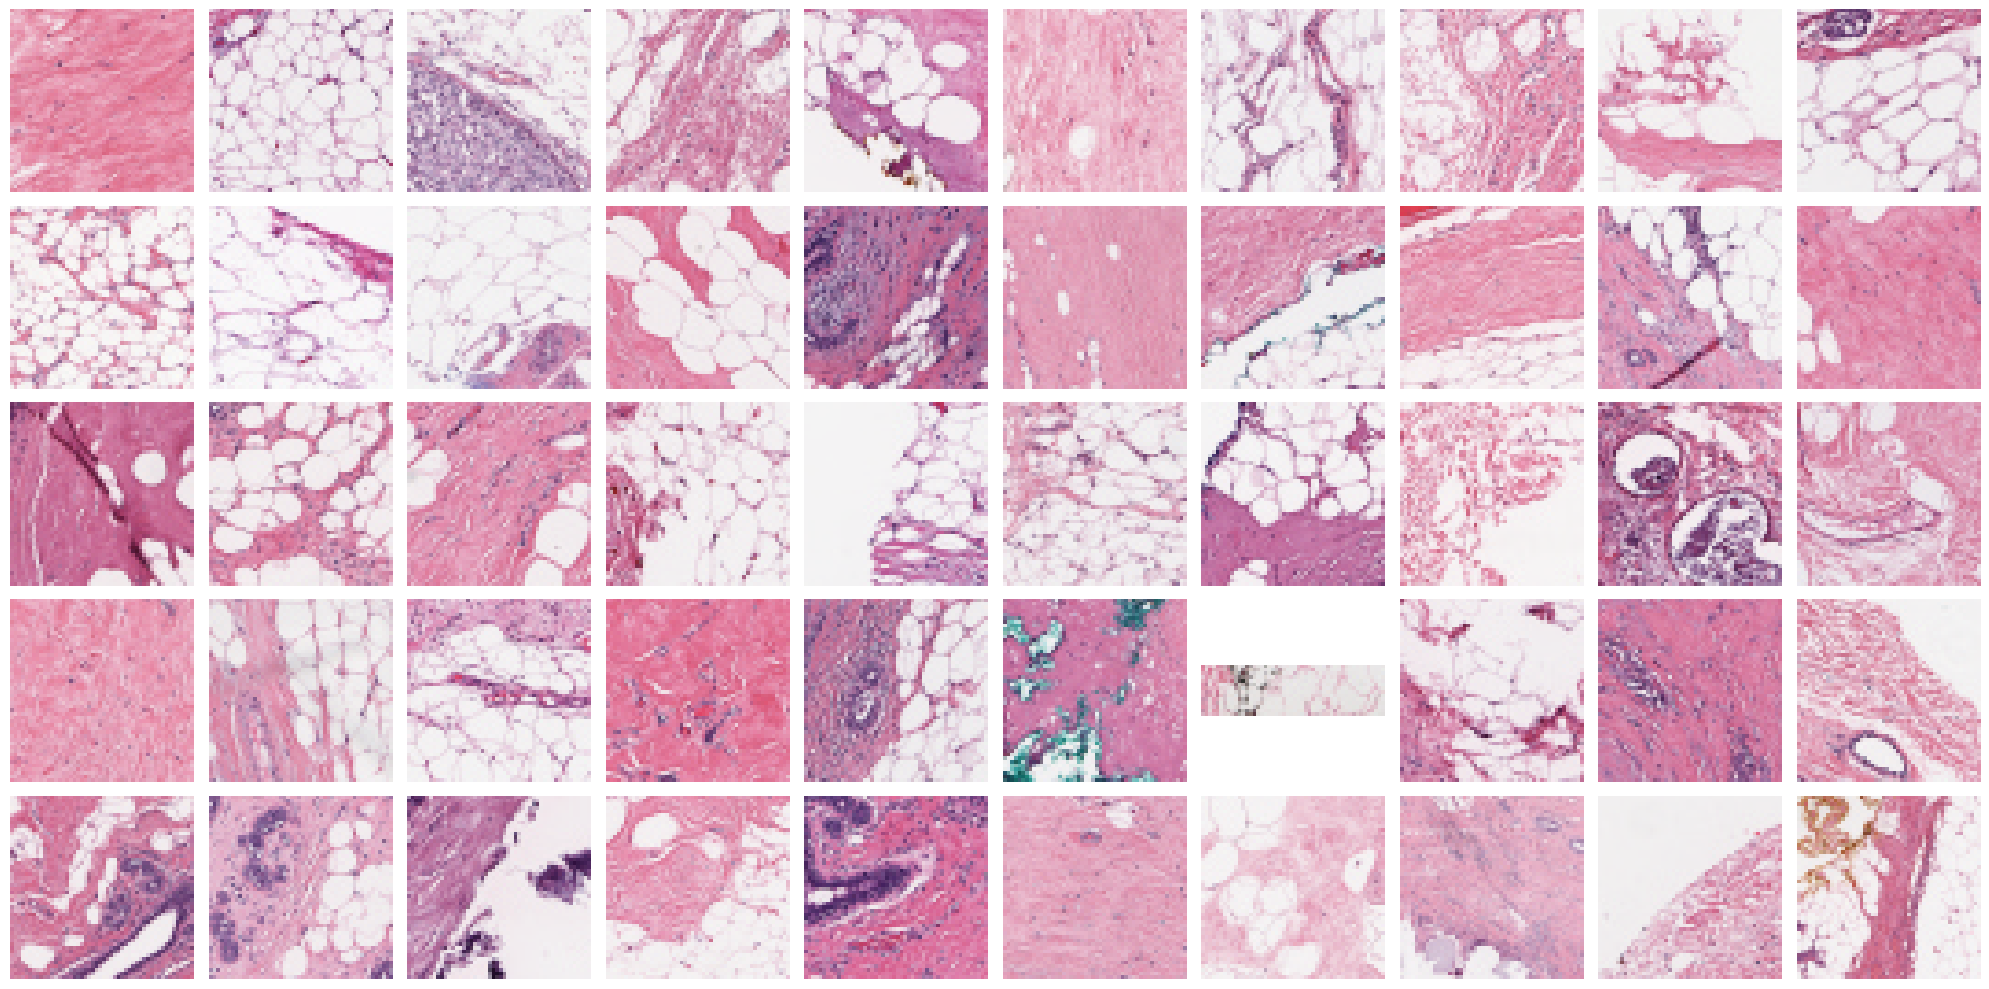

In [12]:
# Create a figure with subplots
fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10 * n]  # Get the index of the image
        image = mpimg.imread(data.loc[idx, "path"])  # Read the image
        ax[n, m].imshow(image)  # Display the image
        ax[n, m].axis("off")  # Turn off axes for a cleaner look

# Adjust layout
plt.tight_layout()
plt.show()

### Insights

* Sometimes we can find artifacts or incomplete patches that have smaller size than 50x50 pixels.
* Patches with cancer look more violet and crowded than healthy ones. Is this really typical for cancer or is it more typical for ductal cells and tissue?
* Though some of the healthy patches are very violet colored too!
* Would be very interesting to hear what criteria are important for a pathologist.
* I assume that the wholes in the tissue belong to the mammary ducts where the milk can flow through.

## Visualising the breast tissue <a class="anchor" id="tissue"></a>

This part is a bit tricky! We have to extract all coordinates of image patches that are stored in the image names. Then we can use the coordinates to reconstruct the whole breast tissue of a patient. This way we can also explore how diseased tissue looks like compared to healthy ones. To simplify this task let's write a method that takes a patient and outcomes a dataframe with coordinates and targets.

In [13]:
def extract_coords(df, column="path"):
    """Extract x and y coordinates from the file path."""
    coords = df[column].str.extract(r"x(?P<x>\d+)_y(?P<y>\d+)")
    df["x"] = coords["x"].astype(int)
    df["y"] = coords["y"].astype(int)
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    """Create a DataFrame for a specific cancer ID."""
    path = f"{base_path}/{patient_id}/{cancer_id}"
    files = listdir(path)

    dataframe = pd.DataFrame(files, columns=["path"])
    dataframe["path"] = path + "/" + dataframe["path"]
    dataframe["target"] = int(cancer_id)

    # Extract x and y coordinates
    dataframe = extract_coords(dataframe, column="path")
    return dataframe

def get_patient_dataframe(patient_id):
    """Combine DataFrames for both cancer ID 0 and 1 for a patient."""
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")

    # Combine dataframes
    patient_df = pd.concat([df_0, df_1], ignore_index=True)
    return patient_df

In [14]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

path  target     x     y
0  /root/.cache/kagglehub/datasets/paultimothymoo...       0   451   751
1  /root/.cache/kagglehub/datasets/paultimothymoo...       0  2451  1401
2  /root/.cache/kagglehub/datasets/paultimothymoo...       0  1551  1351
3  /root/.cache/kagglehub/datasets/paultimothymoo...       0  1801  1751
4  /root/.cache/kagglehub/datasets/paultimothymoo...       0  1701  1401

Ok, now we have the coordinates for each patch, its path to load the image and its target information.

### Binary target visualisation per tissue slice <a class="anchor" id="binarytissue"></a>

Before we will take a look at the whole tissue let's keep it a bit simpler by looking at the target structure in the x-y-space for a handful of patients:

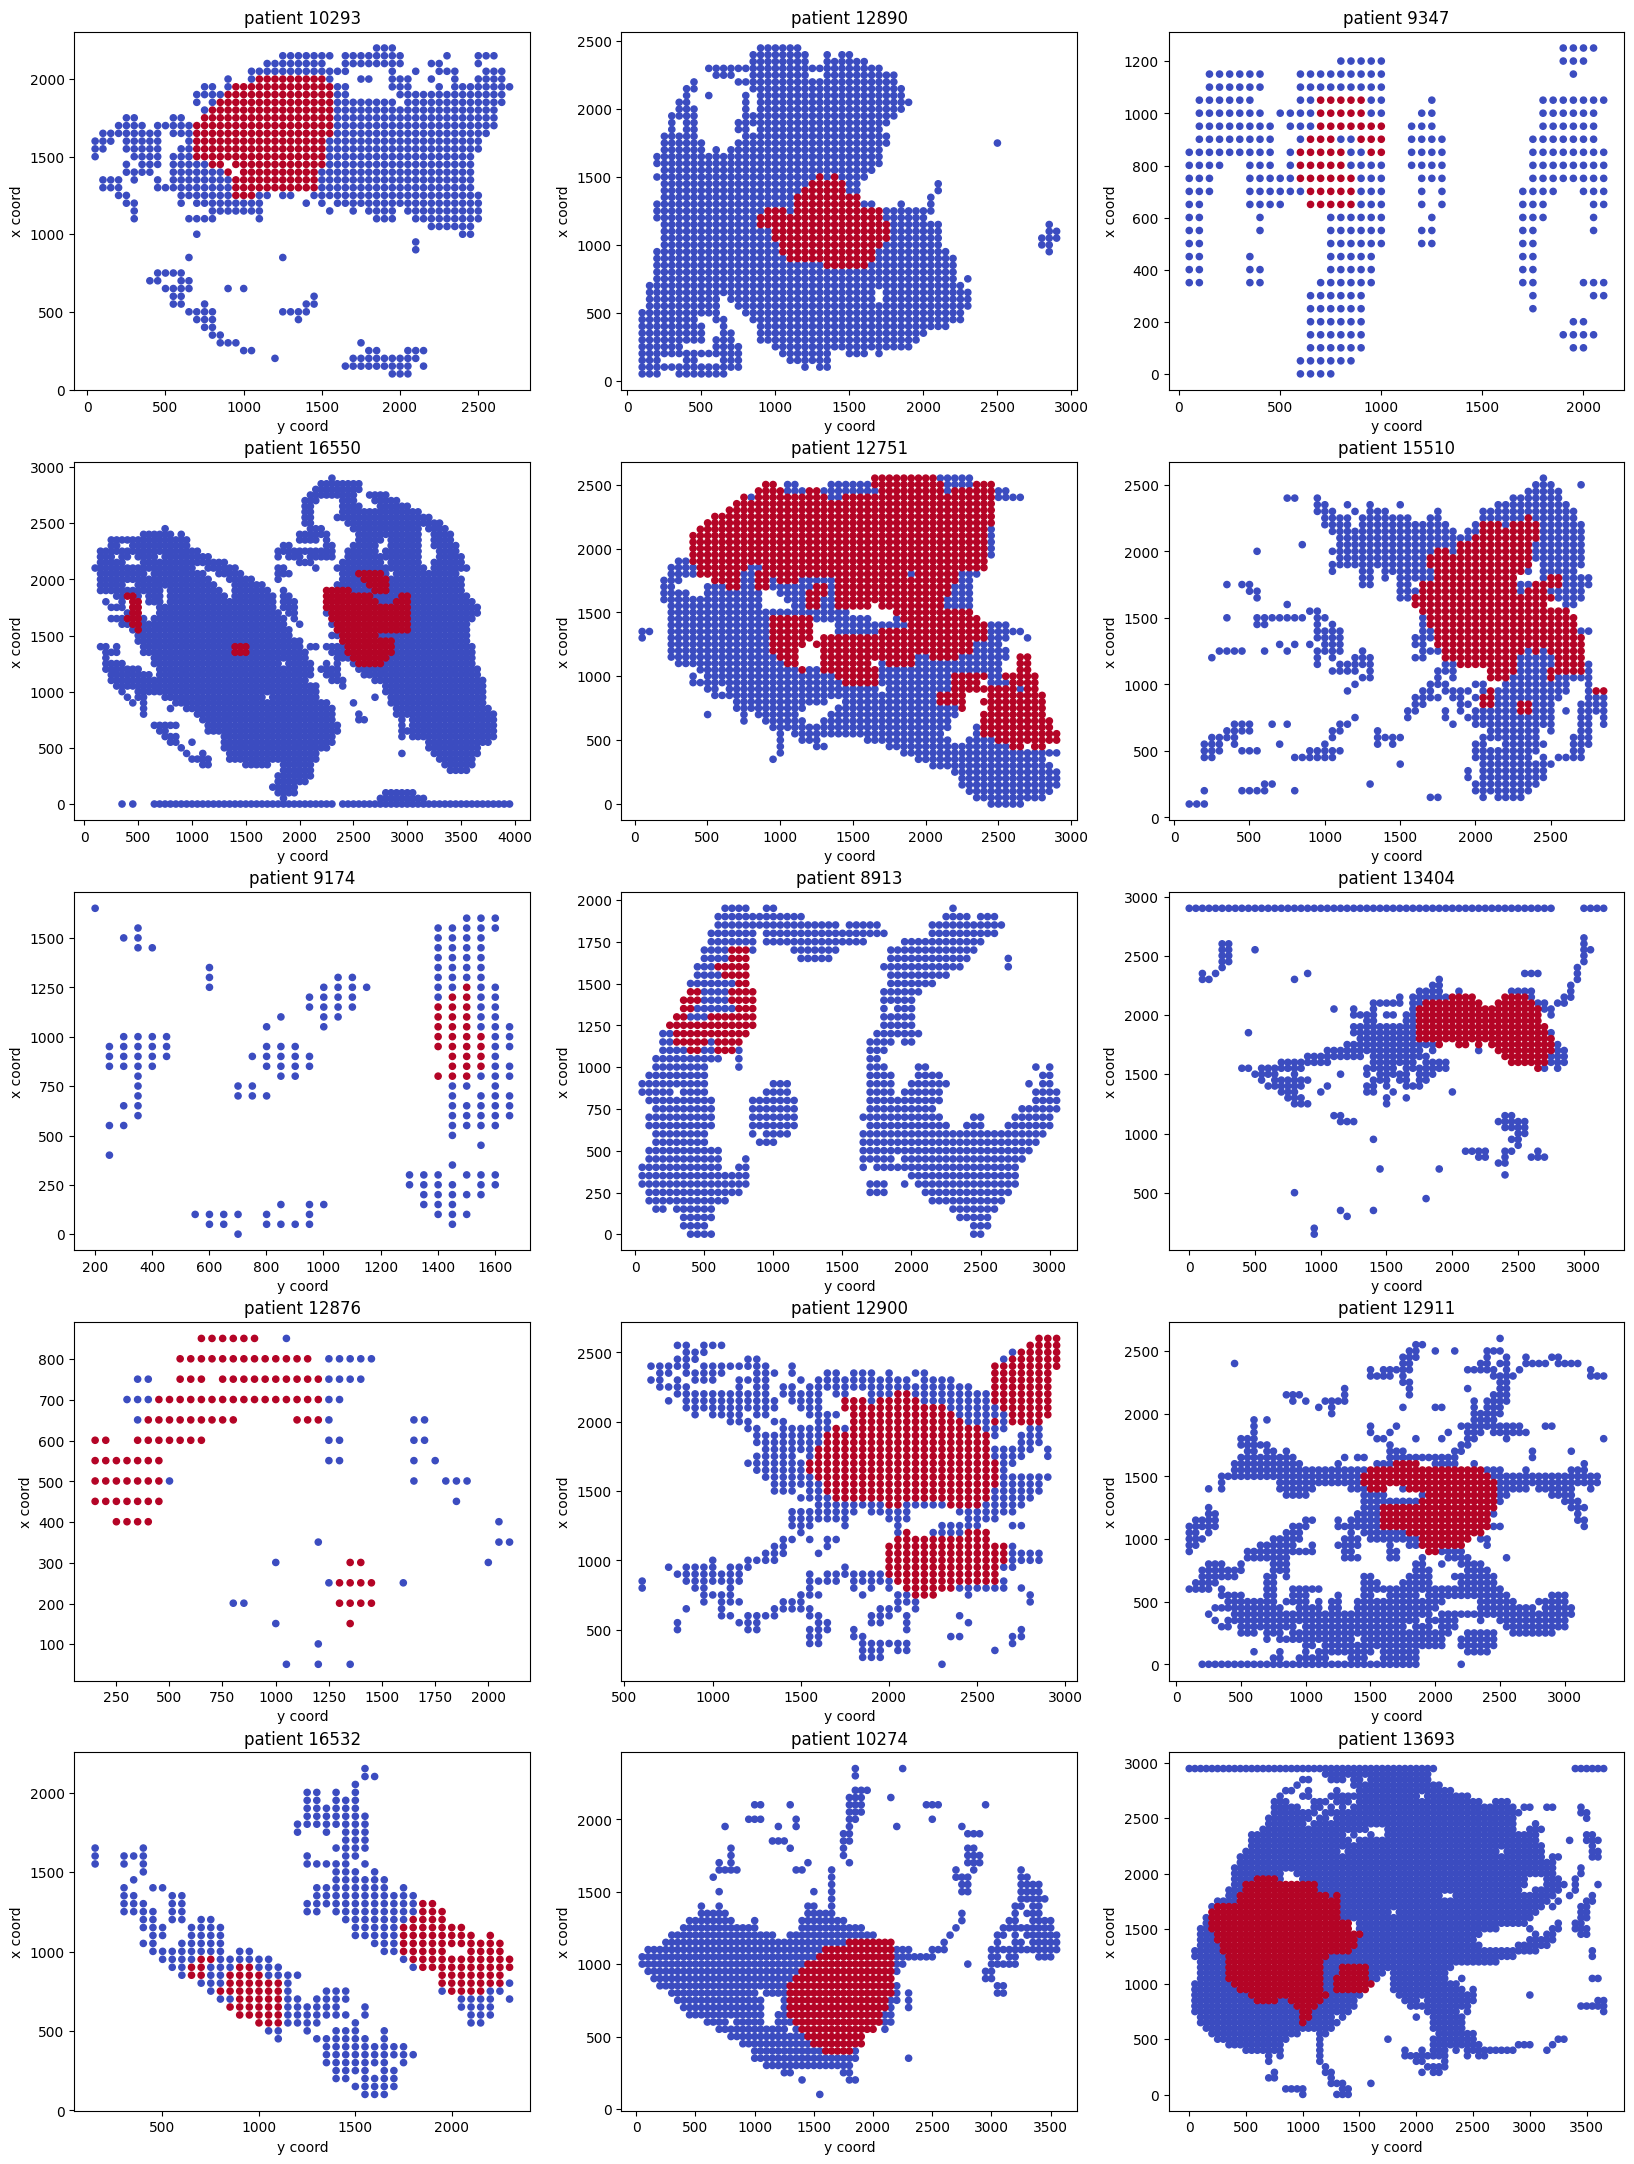

In [15]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)

        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

### Insights

* Sometimes we don't have the full tissue information. It seems that tissue patches have been discarded or lost during preparation.
* Reading the paper (link!) that seems to be related to this data this could also be part of the preprocessing.

### Visualising the breast tissue images <a class="anchor" id="tissueimages"></a>

Ok, now it's time to go one step deeper with our EDA. Given the coordinates of image patches we could try to reconstruct the whole tissue image (not only the targets).

In [16]:
def visualise_breast_tissue(patient_id, pred_df=None):
    """Visualize breast tissue and generate grid and mask representations."""
    # Get the patient data
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max() - 1, example_df.x.max() - 1]

    # Initialize grid and masks
    grid = 255 * np.ones(shape=(max_point[0] + 50, max_point[1] + 50, 3))
    mask = 255 * np.ones(shape=(max_point[0] + 50, max_point[1] + 50, 3))
    mask_proba = np.zeros(shape=(max_point[0] + 50, max_point[1] + 50, 1))

    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()

    broken_patches = []  # To store paths of images that cause issues

    # Process each patch
    for n in range(len(example_df)):
        try:
            # Load the image
            image = mpimg.imread(example_df.path.values[n])

            target = example_df.target.values[n]

            # Get coordinates
            x_coord = int(example_df.x.values[n])
            y_coord = int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            # Place the image on the grid
            grid[y_start:y_end, x_start:x_end] = image

            # Update mask for target 1
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250  # Red
                mask[y_start:y_end, x_start:x_end, 1] = 0    # Green
                mask[y_start:y_end, x_start:x_end, 2] = 0    # Blue

            # Update probability mask if prediction DataFrame is provided
            if pred_df is not None:
                proba = patient_df[
                    (patient_df.x == x_coord) & (patient_df.y == y_coord)
                ].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = float(proba)

        except ValueError:
            # Catch errors and add to broken patches list
            broken_patches.append(example_df.path.values[n])

    return grid, mask, broken_patches, mask_proba

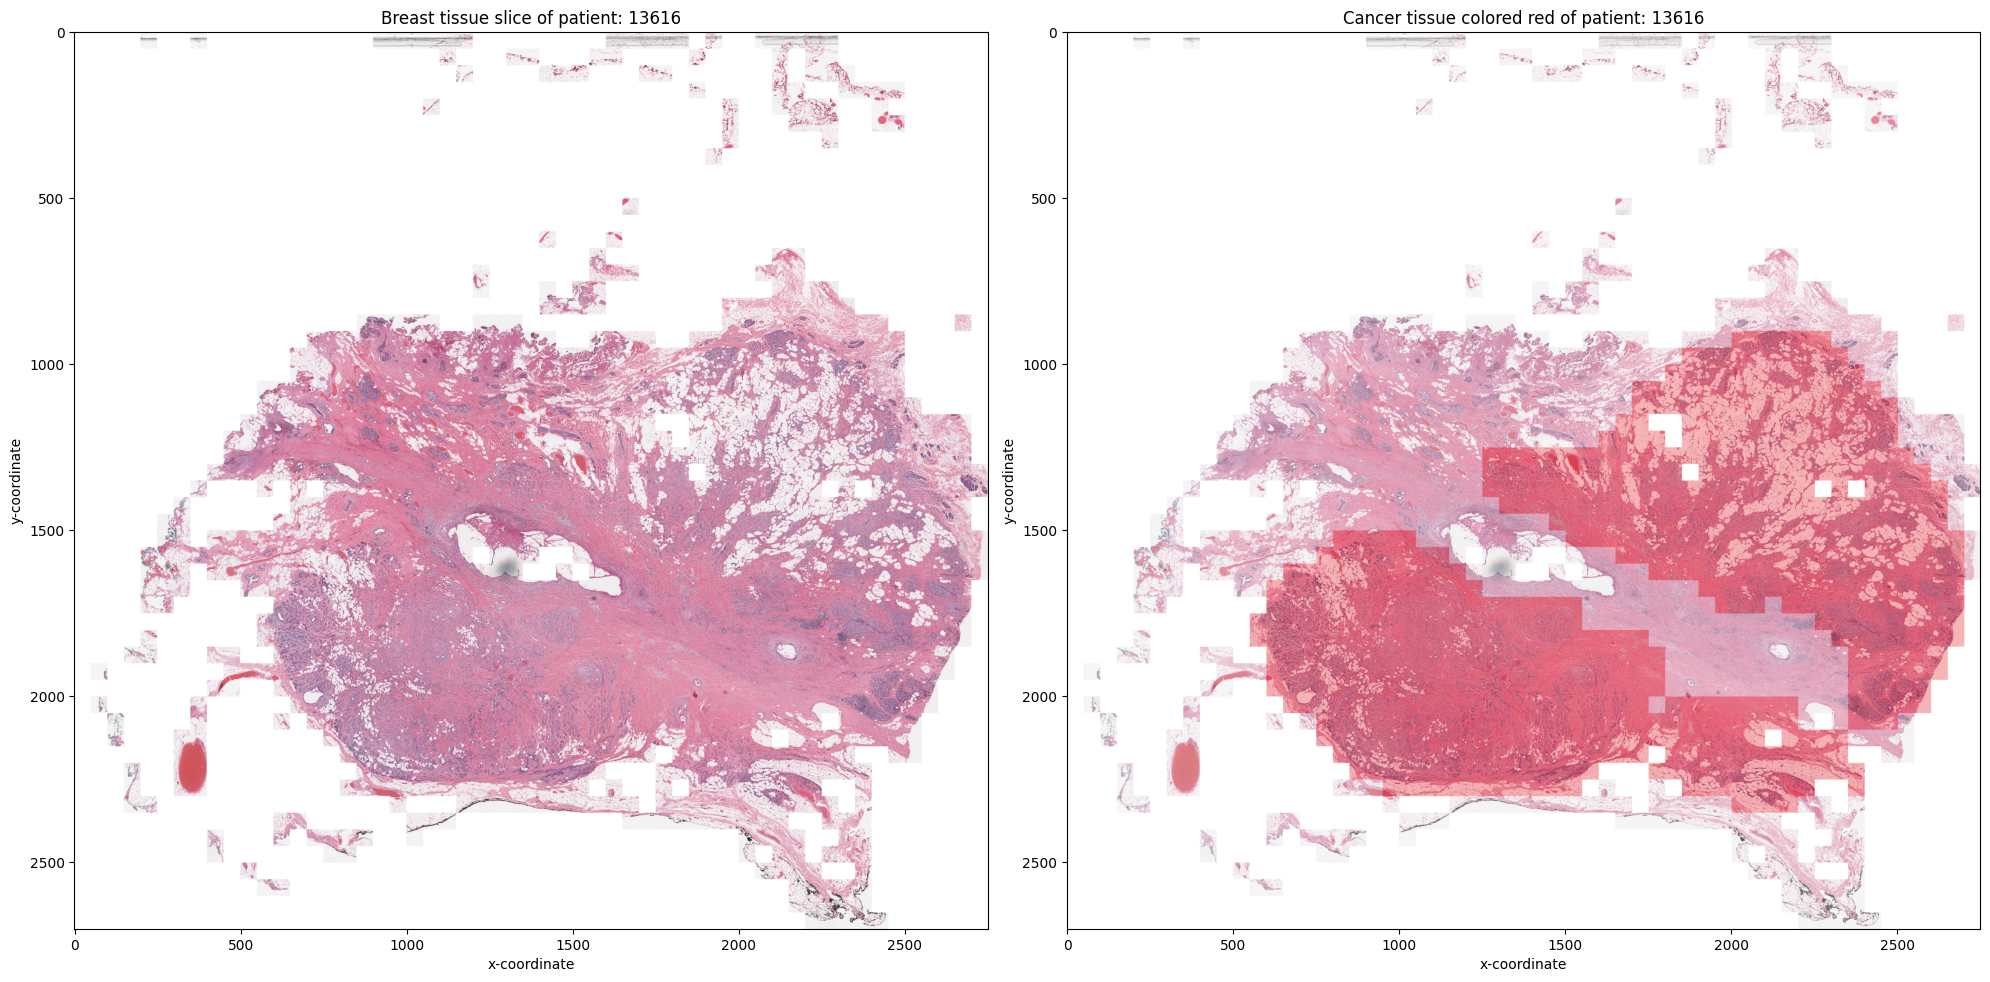

In [17]:
# Example usage with patient ID
example = "13616"  # Patient ID to visualize
grid, mask, broken_patches, _ = visualise_breast_tissue(example)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Display the grid and mask
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)  # Overlay grid on the mask

# Remove grids for both axes
for axis in ax:
    axis.grid(False)

# Set labels and titles for both subplots
for i, title in enumerate(["Breast tissue slice", "Cancer tissue colored red"]):
    ax[i].set_xlabel("x-coordinate")
    ax[i].set_ylabel("y-coordinate")
    ax[i].set_title(f"{title} of patient: {example}")

# Show the plot
plt.tight_layout()
plt.show()

### Insights

* The tissue on the left is shown without target information.
* The image on the right shows the same tissue but cancer is stained with intensive red color.
* Comparing both images it seems that darker, more violet colored tissue has a higher chance to be cancer than those with rose color.
* But as one can see it's not always the case. So we need to ask ourselves if violet tissue patches have more mammary ducts than rose ones. If this is true we have to be careful. Our model might start to learn that mammary ducts are always related to cancer!

Sometimes it's not possible to load an image patch as the path is ill defined. But in our case, we were able to load them all:

In [18]:
broken_patches

[]

# Setting up the machine learning workflow <a class="anchor" id="workflow"></a>

In [19]:
BATCH_SIZE = 128
NUM_CLASSES = 2

torch.manual_seed(0)
np.random.seed(0)

## Validation strategy <a class="anchor" id="validation"></a>

Let's start very simple by selecting 30 % of the patients as test data and the remaining 70 % for training and developing. This seems arbitrary and we should rethink this strategy in the next cycle of our datascience workflow.

A better idea could be to cluster patients with dependence on the size of the tumor, the number of total patches and statistical quantities of area coverd by the patches. The reason behind that is that we would like to have test patients that cover a broad range of possible variations. Only then we can measure something like a generalisation performance.    

In [20]:
patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

print(len(train_ids), len(dev_ids), len(test_ids))

195 42 42


Now it's 70 % train and 15 % for dev and test.

In [21]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids),:].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

In [22]:
train_df.head()

patient_id                                               path  target     x  \
0      10293  /root/.cache/kagglehub/datasets/paultimothymoo...       0   451   
1      10293  /root/.cache/kagglehub/datasets/paultimothymoo...       0  2451   
2      10293  /root/.cache/kagglehub/datasets/paultimothymoo...       0  1551   
3      10293  /root/.cache/kagglehub/datasets/paultimothymoo...       0  1801   
4      10293  /root/.cache/kagglehub/datasets/paultimothymoo...       0  1701   

      y  
0   751  
1  1401  
2  1351  
3  1751  
4  1401

## Target distributions <a class="anchor" id="target_dists"></a>

Let's take a look at the target distribution difference of the datasets:

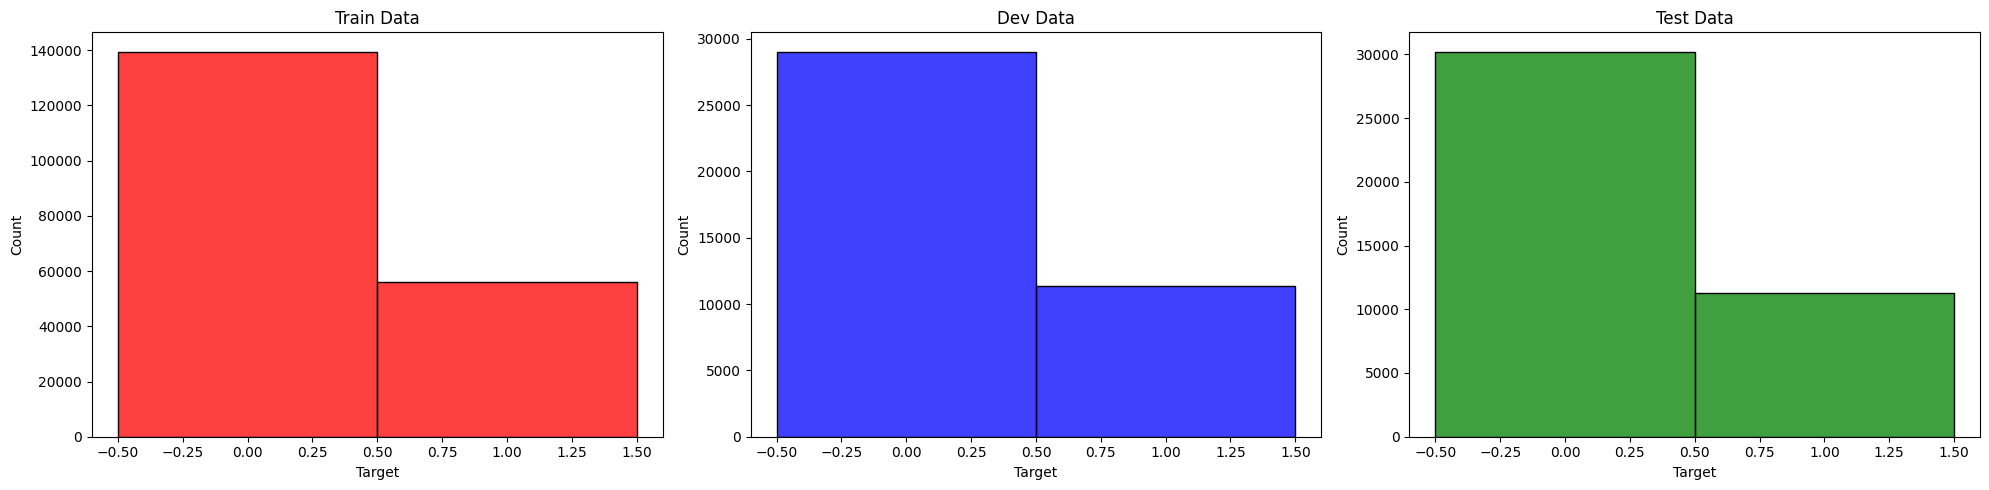

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot for train data
sns.histplot(data=train_df, x="target", ax=ax[0], color="red", discrete=True)
ax[0].set_title("Train Data")
ax[0].set_xlabel("Target")
ax[0].set_ylabel("Count")

# Plot for dev data
sns.histplot(data=dev_df, x="target", ax=ax[1], color="blue", discrete=True)
ax[1].set_title("Dev Data")
ax[1].set_xlabel("Target")
ax[1].set_ylabel("Count")

# Plot for test data
sns.histplot(data=test_df, x="target", ax=ax[2], color="green", discrete=True)
ax[2].set_title("Test Data")
ax[2].set_xlabel("Target")
ax[2].set_ylabel("Count")

# Adjust layout for clarity
plt.tight_layout()
plt.show()

We can see that the test data has more cancer patches compared to healthy tissue patches than train or dev. We should keep this in mind!

In [24]:
train_df['target'].value_counts()

target
0    139490
1     56095
Name: count, dtype: int64

#### Data augmentation

In [25]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(train_df['target'].values)  # Get all unique class labels
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['target'].values)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(class_weights_tensor)


tensor([0.7011, 1.7433], device='cuda:0')


## Creating pytorch image datasets <a class="anchor" id="image_datasets"></a>

It's often a good idea to start as simple as possible and to grow more complex while iterating through the solution. This way we prevent to build up models that are likely overfitted to the available data and we can find out useful ideas in a strategic manner instead of trying out every idea at random.

The simplest transformations we can do for each image are:

* resizing the images to the desired input shape
* performing horizontal and vertical flips

In our case the patches are of shape 50x50x3 and we could set this as our input shape. As CNNs are translational but not rotational invariant, it's a good idea to add flips during training. This way we increase the variety of our data in a meaningful way as each patch could be rotated as well on the tissue slice. As we are not looking at the whole tissue we are not loosing spatial connections between patches and it's not important that some neighboring patches are rotated in different directions.

In [26]:
def my_transform(key="train", plot=False):
    train_sequence = [
        transforms.Resize((50, 50)),
        # Data Augmentations for Training
        transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip
        transforms.RandomRotation(15),  # Reduced rotation to ±15 degrees
        transforms.RandomResizedCrop(size=(50, 50), scale=(0.9, 1.0)),  # Slightly reduced cropping scale
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Reduced color adjustments
    ]

    val_sequence = [
        transforms.Resize((50, 50))  # Only resizing for validation
    ]

    # Convert to tensor and normalize for both train and validation
    if not plot:
        train_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize to ImageNet stats
        ])
        val_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize to ImageNet stats
        ])

    # Define transformations for train and val
    data_transforms = {
        'train': transforms.Compose(train_sequence),
        'val': transforms.Compose(val_sequence)
    }

    return data_transforms[key]


Furthermore we need to create a dataset that loads an image patch of a patient, converts it to RGB, performs the augmentation if it's desired and returns the image, the target, the patient id and the image coordinates.

In [27]:
class BreastCancerDataset(Dataset):

    def __init__(self, df, transform=None):
        self.states = df
        self.transform=transform

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx]
        image = Image.open(image_path)
        image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        if "target" in self.states.columns.values:
            target = int(self.states.target.values[idx])
        else:
            target = None

        return {"image": image,
                "label": target,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

In [28]:
train_dataset = BreastCancerDataset(train_df, transform=my_transform(key="train"))
dev_dataset = BreastCancerDataset(dev_df, transform=my_transform(key="val"))
test_dataset = BreastCancerDataset(test_df, transform=my_transform(key="val"))

In [29]:
image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

Let's take a look at the augmentations:

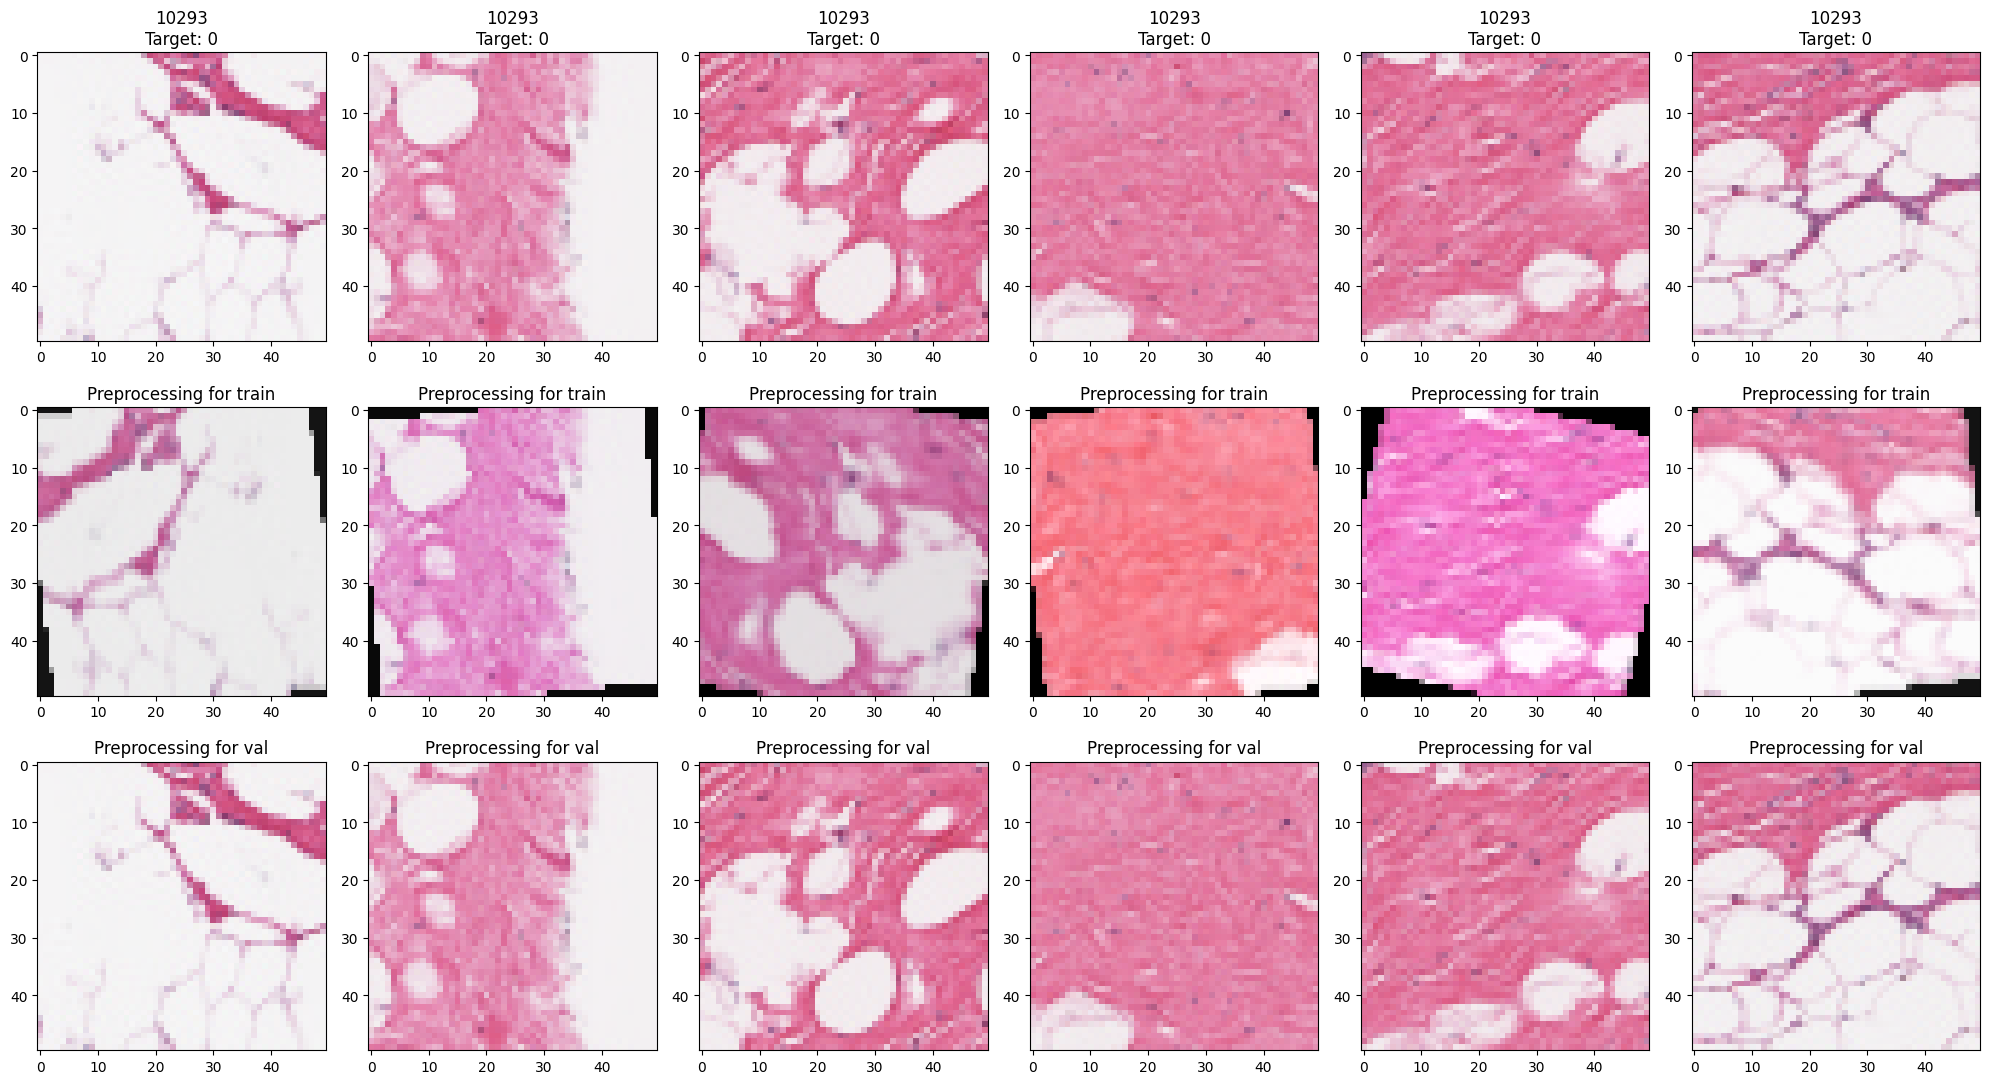

In [30]:
fig, ax = plt.subplots(3, 6, figsize=(20, 11))

# Ensure transforms return images that can be visualized
train_transform = my_transform(key="train", plot=True)
val_transform = my_transform(key="val", plot=True)

for m in range(6):
    filepath = train_df.path.values[m]

    # Open the image using PIL
    image = Image.open(filepath)
    ax[0, m].imshow(image)
    ax[0, m].grid(False)
    ax[0, m].set_title(
        f"{train_df.patient_id.values[m]}\nTarget: {train_df.target.values[m]}"
    )

    # Apply training transformation
    transformed_train_img = train_transform(image)

    # Convert transformed image to numpy array for visualization
    if isinstance(transformed_train_img, torch.Tensor):
        transformed_train_img = transformed_train_img.permute(1, 2, 0).numpy()  # Convert CxHxW to HxWxC
    ax[1, m].imshow(transformed_train_img)
    ax[1, m].grid(False)
    ax[1, m].set_title("Preprocessing for train")

    # Apply validation transformation
    transformed_val_img = val_transform(image)

    # Convert transformed image to numpy array for visualization
    if isinstance(transformed_val_img, torch.Tensor):
        transformed_val_img = transformed_val_img.permute(1, 2, 0).numpy()  # Convert CxHxW to HxWxC
    ax[2, m].imshow(transformed_val_img)
    ax[2, m].grid(False)
    ax[2, m].set_title("Preprocessing for val")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


For validation we have only used the image resizing.

## Creating pytorch dataloaders <a class="anchor" id="dataloaders"></a>

As the gradients for each learning step are computed over batches we benefit from shuffling the training data after each epoch. This way each batch is composed differently and we don't start to learn for specific sequences of images. For validation and training we drop the last batch that often consists less images than the batch size.

In [31]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [32]:
dataloaders = {"train": train_dataloader, "dev": dev_dataloader, "test": test_dataloader}

In [33]:
print(len(dataloaders["train"]), len(dataloaders["dev"]), len(dataloaders["test"]))

1528 315 325


In [34]:
# Define the ResNet structure for your task
networks = {
    'resnet18_light': {
        'block': ResidualBlock,
        'stage_args': [
            (32, 64, 3, False)
        ],
        'dropout': True,  # Enable dropout
        'p': 0.5  # Dropout probability
    }
}

def get_resnet(name):
    return ResNet(**networks[name])

In [35]:
to_float= torch.float
to_long = torch.long

In [ ]:
lr = 0.0005
weight_decay = 1e-3
epochs = 50

# Model and file paths
name = 'resnet18_light'
version = 4
checkpoint_path = f'{base_dir}/checkpoint/{name}_{version}_checkpoint.pth'
model_path = f'{base_dir}/models/{name}_{version}_checkpoint.pth'
history_path = f'{base_dir}/history/{name}_{version}.pth'

if os.path.exists(checkpoint_path):
    # Resume training from checkpoint
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model = get_resnet(name).to(device)
    model.load_state_dict(checkpoint['model_state'])

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer.load_state_dict(checkpoint['optimizer_state'])

    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    if checkpoint['scheduler_state'] is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state'])

    start_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['best_val_acc']
    train_metrics_history = checkpoint['train_history']
    val_metrics_history = checkpoint['val_history']
    lr_history = checkpoint['lr_history']

    print(f"Training will resume from epoch {start_epoch}.\n")

else:
    # Start new training
    print(f"Training new model: {name}\n")

    # Initialize model and optimizer
    model = get_resnet(name).to(device)
    model.apply(initialize_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Define scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    # Initialize metrics and state
    start_epoch = 0
    best_val_acc = 0.0
    train_metrics_history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    val_metrics_history = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    lr_history = []

# Train model
train_metrics_history, val_metrics_history, lr_history = train_model(
    model, optimizer, train_dataloader, dev_dataloader,
    device=device, dtype=torch.float32, epochs=epochs,
    scheduler=scheduler, verbose=True,
    checkpoint_path=checkpoint_path,
    history_path=history_path,class_weights_tensor=class_weights_tensor
)

# Save final model and history after training completes
torch.save(model.state_dict(), model_path)
print(f"Final model saved at: {model_path}")

with open(history_path, 'wb') as f:
    pickle.dump((train_metrics_history, val_metrics_history, lr_history), f)
print(f"Training history saved at: {history_path}")

# Evaluate model on the test set
test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(test_dataloader, model, device=device)
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, "
      f"Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

# Plot metrics
plot_all_metrics(train_metrics_history, val_metrics_history)
plot_learning_rate(lr_history)
plot_loss(train_metrics_history['loss'])

Training new model: resnet18_light

class_weights_tensor
Epoch 1/50
  Batch 0, Loss = 1.3375
  Batch 100, Loss = 0.4016
  Batch 200, Loss = 0.4595
  Batch 300, Loss = 0.4524
  Batch 400, Loss = 0.5320
  Batch 500, Loss = 0.4471
  Batch 600, Loss = 0.3593
  Batch 700, Loss = 0.4258
  Batch 800, Loss = 0.5365
  Batch 900, Loss = 0.2843
  Batch 1000, Loss = 0.4271
  Batch 1100, Loss = 0.2484
  Batch 1200, Loss = 0.4162
  Batch 1300, Loss = 0.3832
  Batch 1400, Loss = 0.3399
  Batch 1500, Loss = 0.4207
  Training Loss: 0.4145, Accuracy: 0.8210, Precision: 0.8399, Recall: 0.8210, F1 Score: 0.8262
  Validation Accuracy: 0.8458, Precision: 0.8451, Recall: 0.8458, F1 Score: 0.8454
  Checkpoint saved at epoch 1
Epoch 2/50
  Batch 0, Loss = 0.4118
  Batch 100, Loss = 0.3761
  Batch 200, Loss = 0.3001
  Batch 300, Loss = 0.3811
  Batch 400, Loss = 0.3563
  Batch 500, Loss = 0.3611
  Batch 600, Loss = 0.3936
  Batch 700, Loss = 0.4030
  Batch 800, Loss = 0.3694
  Batch 900, Loss = 0.3480
  Batch 1